# DR DETECTION (DR NO DR)

Inisialisasi program yang dibutuhkan untuk menjalankan proses deteksi DR.

In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

Inisialisasi program yang dibutuhkan untuk menjalankan proses deteksi DR.

In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy, AUC
from sklearn.model_selection import train_test_split

!pip install tensorflow-addons
import tensorflow_addons
from tensorflow_addons.metrics import F1Score, CohenKappa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.7 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

Import library kaggle kedalam google colab.

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Untuk menjalankan program harus memiliki kode API dari keaggle berupa file bernama kaggle.json dan di import kedalam program.

In [ ]:
import zipfile
from google.colab import files

#upload the kaggle json file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fauzyahaprillia","key":"cace8c576de9cf4f1e95679f87f5ec53"}'}

Untuk membuat directory (comment), mengcopy file kaggle.json pada laptop kedalam google colab, dan modify permission atas sebuah directory (izin akses). Dengan adanya permission maka kita bisa melihat akses data sheet.

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mendownload dataset kaggle yang memiliki format zip. Dan mengubah menjadi folder di dalam google colab.

In [ ]:
!kaggle datasets download sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

100% 425M/427M [00:02<00:00, 203MB/s]
100% 427M/427M [00:02<00:00, 217MB/s]


In [ ]:
#folder is unzipped, may take a few moments to populate

with zipfile.ZipFile('/content/diabetic-retinopathy-224x224-gaussian-filtered.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Program untuk klasifikasi pada diagnosa DR.

In [ ]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'/content/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


Berikut merupakan kode yang digunakan untuk Menghasilkan plot bar horizontal yang menunjukkan jumlah nilai unik dalam kolom "type".

<Axes: >

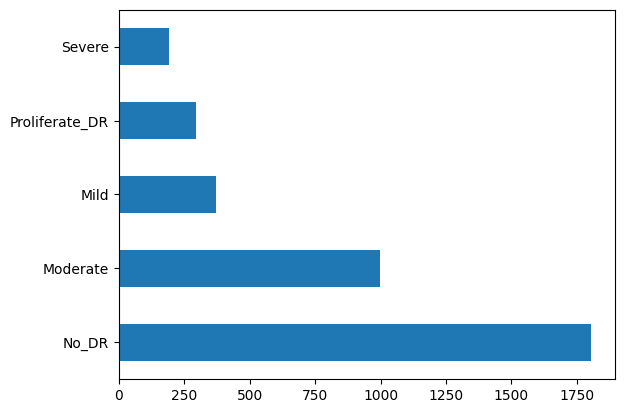

In [ ]:
## Generates a horizontal bar plot showing the count of unique values in the type column
df['type'].value_counts().plot(kind='barh')

Bagian ini adalah Memperlihatkan diagram batang horizontal yang menunjukkan jumlah label klasifikasi biner unik dalam tipe biner.

<Axes: >

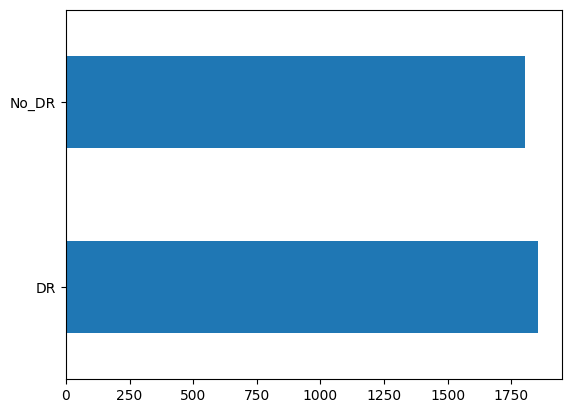

In [ ]:
## Generates a horizontal bar plot showing the count of unique binary classification labels in the binary_type
df['binary_type'].value_counts().plot(kind='barh')

Program dibawah merupakan kode yang menunjukkan bagian folder yang akan muncul dibagian kiri layar google colab untuk masing-masing klasifikasi penyakit DR

In [ ]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



Kode dibawah ini adalah komentar yang menjelaskan bahwa pada program tersebut dilakukan proses pembuatan direktori kerja untuk data latih, validasi, dan tes.

In [ ]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


Kode dibawah ini adalah komentar yang menjelaskan bahwa program tersebut dilakukan penyalinan (copy) gambar ke dalam direktori kerja yang sesuai. Selanjutnya, pada baris kedua, terdapat deklarasi variabel "src_dir" yang berisi alamat direktori asal (source directory) yang merupakan rute absolut dari folder "gaussian_filtered_images/gaussian_filtered_images" di dalam folder "content". Variabel ini akan digunakan pada kode program selanjutnya untuk mengambil dan memindahkan file gambar ke direktori tujuan yang sesuai.

In [ ]:
# Copy images to respective working directory
src_dir = r'/content/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


# CNN

**NO AUGMENTATION**

Kode "# Setting up ImageDataGenerator for train/val/test" adalah komentar yang menjelaskan bahwa pada program ini dilakukan pengaturan (setup) objek ImageDataGenerator untuk data latih, validasi, dan tes.

In [ ]:
# Setting up ImageDataGenerator for train/val/test

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


1. Input layer: This layer defines the input shape of the data. In this case, the input shape is set to (224, 224, 3), which means the input images have a size of 224x224 and have 3 color channels (RGB).

2. Convolution layer + Activation function: This layer applies a convolution operation to the input image using a kernel or filter of size (3,3). It uses the Rectified Linear Unit (ReLU) activation function to introduce non-linearity in the model.

3. Pooling layer: This layer reduces the dimensionality of the output of the convolution layer. In this case, the MaxPooling2D layer is used which downsamples the input along the spatial dimensions using the maximum value in each patch of the feature map.

4. BatchNormalization layer: This layer normalizes the activations of the previous layer. The 3 layers are repeated 2 times with increasing filters (8, 16, 32) respectively.

5. Flatten layer: This layer converts the output of the previous layer to a 1D vector.

6. Fully Connected layer: This layer is a traditional neural network layer with 32 units and uses the ReLU activation function.

7. Dropout layer: This layer applies a regularization technique by randomly setting a fraction of the input units to 0 during training to reduce overfitting.

8. Output layer: This layer is a fully connected layer with 2 units and uses the softmax activation function for multi-class classification.

After building the model, the model is compiled with the Adam optimizer and  Binary Crossentropy loss function. The accuracy metric is also included. Finally, the model is trained using the fit method on the training data for 30 epochs and evaluated on the validation data.

Berikut adalah komentar dalam kode program yang digunakan untuk menjelaskan bahwa bagian kode yang mengikuti adalah bagian yang digunakan untuk membangun model (model building).

In [ ]:
# Building the model 8 LAYER CNN

CNN_model = tf.keras.Sequential([
    layers.Conv2D(16, (3,3), padding="same", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(1,1)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

CNN_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc','AUC',tensorflow_addons.metrics.F1Score(num_classes=2, average='weighted'),tensorflow_addons.metrics.CohenKappa(num_classes=5)])

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_batches.classes), y=train_batches.classes)

# convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

history = CNN_model.fit(train_batches,
                    epochs=20,
                    validation_data=val_batches,
                    class_weight=class_weights_dict)

Epoch 1/20
81/81 [==============================] - 247s 3s/step - loss: 0.2610 - acc: 0.8993 - auc: 0.9597 - f1_score: 0.8993 - cohen_kappa: 0.7985 - val_loss: 0.7189 - val_acc: 0.5073 - val_auc: 0.6716 - val_f1_score: 0.3414 - val_cohen_kappa: 0.0000e+00
Epoch 2/20
81/81 [==============================] - 246s 3s/step - loss: 0.2147 - acc: 0.9235 - auc: 0.9686 - f1_score: 0.9235 - cohen_kappa: 0.8470 - val_loss: 0.8691 - val_acc: 0.5073 - val_auc: 0.6335 - val_f1_score: 0.3414 - val_cohen_kappa: 0.0000e+00
Epoch 3/20
81/81 [==============================] - 218s 3s/step - loss: 0.2020 - acc: 0.9208 - auc: 0.9715 - f1_score: 0.9208 - cohen_kappa: 0.8416 - val_loss: 0.7469 - val_acc: 0.5073 - val_auc: 0.5304 - val_f1_score: 0.3414 - val_cohen_kappa: 0.0000e+00
Epoch 4/20
81/81 [==============================] - 216s 3s/step - loss: 0.1811 - acc: 0.9344 - auc: 0.9768 - f1_score: 0.9344 - cohen_kappa: 0.8688 - val_loss: 0.6858 - val_acc: 0.5291 - val_auc: 0.6015 - val_f1_score: 0.4226 - 

Kode ini digunakan untuk menyimpan model yang telah dibangun ke dalam file dengan format tertentu. Metode save() digunakan untuk menyimpan model ke dalam file dengan nama CNN.model.

In [ ]:
CNN_model.save('CNN.model')

Kode dalam program ini digunakan untuk mengevaluasi performa model yang telah dibangun pada data uji (test data) dengan menggunakan metode evaluate_generator().. Dalam hal ini, fungsi evaluate_generator() dipanggil dengan parameter test_batches, yang merupakan generator untuk batch data uji, dan verbose yang diatur ke 1 untuk menampilkan informasi yang lebih rinci selama proses evaluasi.

In [ ]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)

<ipython-input-27-b08fd55361be>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 8s 450ms/step - loss: 0.6560 - acc: 0.7345
Loss:  0.6559587121009827
Accuracy:  0.7345454692840576


Untuk mengimpor library matplotlib.pyplot, yang merupakan library untuk visualisasi data dalam bahasa pemrograman Python

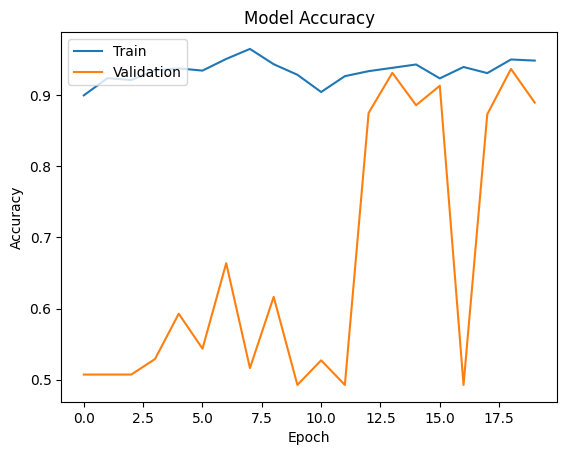

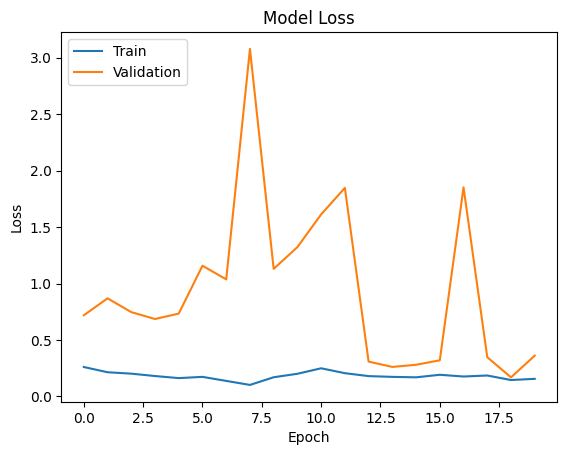

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**WITH AUGMENTATION**

Kode "batch_size = 32" merupakan sebuah perintah dalam bahasa pemrograman Python yang menetapkan nilai 32 sebagai ukuran batch yang akan digunakan dalam proses pelatihan model.

In [ ]:
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.15,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.15,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.15,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

train_batches2 = train_datagen.flow_from_directory(train_path,
                                                  target_size=(224,224),
                                                  shuffle=True,
                                                  batch_size=batch_size)

val_batches2 = val_datagen.flow_from_directory(val_path,
                                              target_size=(224,224),
                                              shuffle=True,
                                              batch_size=batch_size)

test_batches2 = test_datagen.flow_from_directory(test_path,
                                                target_size=(224,224),
                                                shuffle=False,
                                                batch_size=batch_size)

print('Number of train batches:', len(train_batches2))
print('Number of validation batches:', len(val_batches2))
print('Number of test batches:', len(test_batches2))

print('Total number of train images:', len(train_batches2) * batch_size)
print('Total number of validation images:', len(val_batches2) * batch_size)
print('Total number of test images:', len(test_batches2) * batch_size)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Number of train batches: 81
Number of validation batches: 18
Number of test batches: 18
Total number of train images: 2592
Total number of validation images: 576
Total number of test images: 576


Kode "# Building the model" adalah sebuah komentar (comment) dalam bahasa pemrograman Python yang menunjukkan bahwa akan mulai membuat model pembelajaran mesin pada bagian kode selanjutnya.

In [ ]:
# Building the model 8 LAYER CNN

CNNaug_model = tf.keras.Sequential([
    layers.Conv2D(16, (3,3), padding="same", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(1,1)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

CNNaug_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc','AUC',tensorflow_addons.metrics.F1Score(num_classes=2, average='weighted'),tensorflow_addons.metrics.CohenKappa(num_classes=5)])

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_batches2.classes), y=train_batches2.classes)

# convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

history = CNNaug_model.fit(train_batches2,

                    epochs=20,
                    validation_data=val_batches2,
                    class_weight=class_weights_dict)

Epoch 1/20
81/81 [==============================] - 50s 485ms/step - loss: 0.3697 - acc: 0.8489 - auc: 0.9209 - f1_score: 0.8490 - cohen_kappa: 0.6979 - val_loss: 0.7525 - val_acc: 0.5073 - val_auc: 0.5969 - val_f1_score: 0.3414 - val_cohen_kappa: 0.0000e+00
Epoch 2/20
81/81 [==============================] - 39s 487ms/step - loss: 0.2861 - acc: 0.8825 - auc: 0.9496 - f1_score: 0.8825 - cohen_kappa: 0.7651 - val_loss: 1.0917 - val_acc: 0.5073 - val_auc: 0.6172 - val_f1_score: 0.3414 - val_cohen_kappa: 0.0000e+00
Epoch 3/20
81/81 [==============================] - 40s 492ms/step - loss: 0.2708 - acc: 0.8938 - auc: 0.9532 - f1_score: 0.8938 - cohen_kappa: 0.7877 - val_loss: 2.2047 - val_acc: 0.5073 - val_auc: 0.5073 - val_f1_score: 0.3414 - val_cohen_kappa: 0.0000e+00
Epoch 4/20
81/81 [==============================] - 41s 501ms/step - loss: 0.2499 - acc: 0.9087 - auc: 0.9585 - f1_score: 0.9086 - cohen_kappa: 0.8174 - val_loss: 0.4555 - val_acc: 0.8745 - val_auc: 0.9411 - val_f1_score: 0

dibawah ini adalah perintah atau fungsi dalam bahasa pemrograman Python untuk menyimpan model neural network pada file yang diberi nama 'CNNaug_5_class.model' dengan format yang disebut sebagai Keras model format.

In [ ]:
CNNaug_model.save('CNNaug.model')

Kode dibawah ini merupakan sebuah perintah atau fungsi dalam bahasa pemrograman Python untuk mengevaluasi model neural network yang telah di-training sebelumnya dengan menggunakan dataset yang berbeda (test_batches2) untuk menghitung beberapa metrik evaluasi yang umum digunakan, yaitu: loss, akurasi (accuracy), area under the curve (AUC), F1-score, dan kappa Cohen.

In [ ]:
loss, acc, auc, f1_score, cohen_kappa = CNNaug_model.evaluate(test_batches2, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)
print("AUC: ", auc)
print("F1 Score: ", f1_score)
print("Cohen Kappa: ", cohen_kappa)

18/18 [==============================] - 6s 345ms/step - loss: 0.2951 - acc: 0.8782 - auc: 0.9438 - f1_score: 0.8774 - cohen_kappa: 0.7558
Loss:  0.29507118463516235
Accuracy:  0.8781818151473999
AUC:  0.943824827671051
F1 Score:  0.8774383068084717
Cohen Kappa:  0.7558082342147827


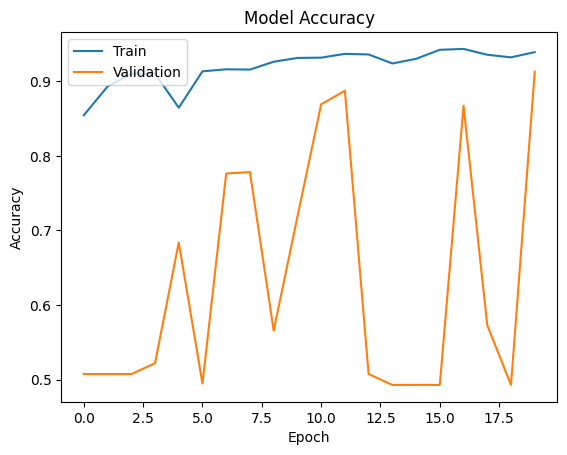

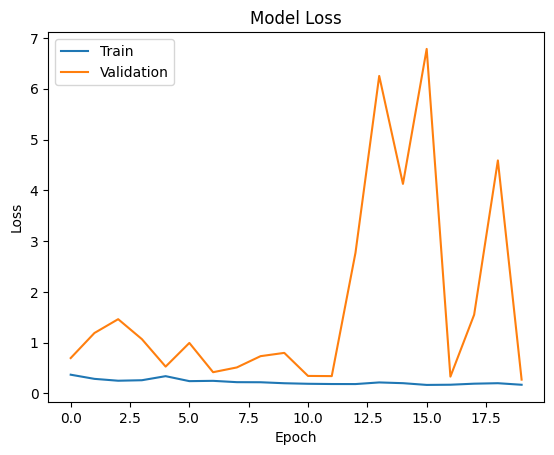

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# MOBILENET V2

In this code, the pre-trained MobileNetV2 model is loaded without its top layer, and a new classification layer is added on top. The weights of the pre-trained layers are then frozen to prevent them from being re-trained. The model is then compiled with a binary crossentropy loss function and several evaluation metrics, including accuracy, AUC, F1 Score, and Cohen's kappa. The model is then trained on the given data with class weights computed to balance the dataset

**NO AUGMENTATION**

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained MobileNetV2 model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the pre-trained layers
base_model.trainable = False

# Add the top layer for classification
MobileNetV2_model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation='softmax')
])

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_batches.classes), y=train_batches.classes)

# convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

# Compile the model
MobileNetV2_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc', 'AUC', tensorflow_addons.metrics.F1Score(num_classes=2, average='weighted'), tensorflow_addons.metrics.CohenKappa(num_classes=5)])

# Train the model
history = MobileNetV2_model.fit(train_batches,
                           epochs=20,
                           validation_data=val_batches,
                           class_weight=class_weights_dict)


Epoch 1/20
81/81 [==============================] - 25s 137ms/step - loss: 0.2818 - acc: 0.8985 - auc: 0.9536 - f1_score: 0.8985 - cohen_kappa: 0.7971 - val_loss: 0.1969 - val_acc: 0.9345 - val_auc: 0.9660 - val_f1_score: 0.9345 - val_cohen_kappa: 0.8691
Epoch 2/20
81/81 [==============================] - 9s 112ms/step - loss: 0.1721 - acc: 0.9500 - auc: 0.9753 - f1_score: 0.9500 - cohen_kappa: 0.9001 - val_loss: 0.1763 - val_acc: 0.9400 - val_auc: 0.9650 - val_f1_score: 0.9400 - val_cohen_kappa: 0.8800
Epoch 3/20
81/81 [==============================] - 10s 126ms/step - loss: 0.1531 - acc: 0.9543 - auc: 0.9777 - f1_score: 0.9543 - cohen_kappa: 0.9087 - val_loss: 0.1720 - val_acc: 0.9400 - val_auc: 0.9772 - val_f1_score: 0.9400 - val_cohen_kappa: 0.8801
Epoch 4/20
81/81 [==============================] - 11s 130ms/step - loss: 0.1324 - acc: 0.9602 - auc: 0.9823 - f1_score: 0.9602 - cohen_kappa: 0.9204 - val_loss: 0.1540 - val_acc: 0.9418 - val_auc: 0.9816 - val_f1_score: 0.9418 - val_c

In [ ]:
MobileNetV2_model.save('MobileNetV2.model')

In [ ]:
loss, acc, auc, f1_score, cohen_kappa = MobileNetV2_model.evaluate(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)
print("AUC: ", auc)
print("F1 Score: ", f1_score)
print("Cohen Kappa: ", cohen_kappa)

18/18 [==============================] - 3s 162ms/step - loss: 0.0968 - acc: 0.9691 - auc: 0.9880 - f1_score: 0.9691 - cohen_kappa: 0.9381
Loss:  0.09683637320995331
Accuracy:  0.9690909385681152
AUC:  0.9880396723747253
F1 Score:  0.9690800905227661
Cohen Kappa:  0.9381458163261414


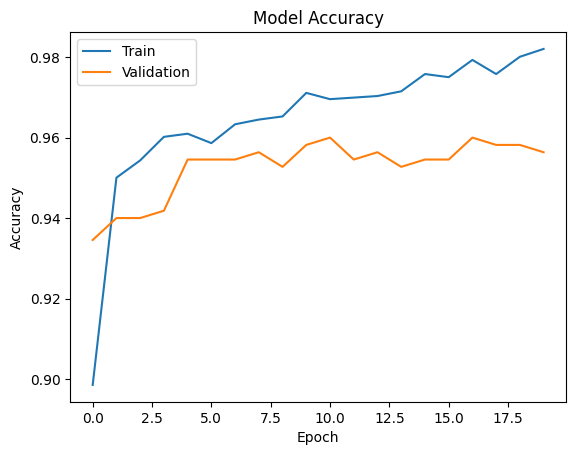

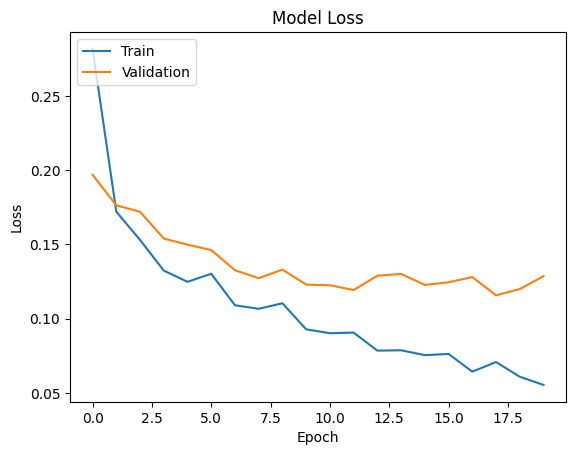

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**WITH AUGMENTATION**

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained MobileNetV2 model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the pre-trained layers
base_model.trainable = False

# Add the top layer for classification
MobileNetV2aug_model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation='softmax')
])

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_batches2.classes), y=train_batches2.classes)

# convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

# Compile the model
MobileNetV2aug_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc', 'AUC', tensorflow_addons.metrics.F1Score(num_classes=2, average='weighted'), tensorflow_addons.metrics.CohenKappa(num_classes=5)])

# Train the model
history = MobileNetV2aug_model.fit(train_batches2,
                           epochs=20,
                           validation_data=val_batches2,
                           class_weight=class_weights_dict)


Epoch 1/20
81/81 [==============================] - 52s 579ms/step - loss: 0.2864 - acc: 0.8973 - auc: 0.9528 - f1_score: 0.8973 - cohen_kappa: 0.7946 - val_loss: 0.2156 - val_acc: 0.9364 - val_auc: 0.9656 - val_f1_score: 0.9364 - val_cohen_kappa: 0.8727
Epoch 2/20
81/81 [==============================] - 54s 669ms/step - loss: 0.1966 - acc: 0.9360 - auc: 0.9710 - f1_score: 0.9360 - cohen_kappa: 0.8720 - val_loss: 0.2007 - val_acc: 0.9345 - val_auc: 0.9640 - val_f1_score: 0.9345 - val_cohen_kappa: 0.8691
Epoch 3/20
81/81 [==============================] - 38s 466ms/step - loss: 0.1919 - acc: 0.9387 - auc: 0.9706 - f1_score: 0.9387 - cohen_kappa: 0.8775 - val_loss: 0.1900 - val_acc: 0.9455 - val_auc: 0.9685 - val_f1_score: 0.9455 - val_cohen_kappa: 0.8909
Epoch 4/20
81/81 [==============================] - 42s 514ms/step - loss: 0.1652 - acc: 0.9465 - auc: 0.9765 - f1_score: 0.9465 - cohen_kappa: 0.8931 - val_loss: 0.1923 - val_acc: 0.9345 - val_auc: 0.9662 - val_f1_score: 0.9345 - val_

In [ ]:
MobileNetV2aug_model.save('MobileNetV2aug.model')

In [ ]:
loss, acc, auc, f1_score, cohen_kappa = MobileNetV2aug_model.evaluate(test_batches2, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)
print("AUC: ", auc)
print("F1 Score: ", f1_score)
print("Cohen Kappa: ", cohen_kappa)

18/18 [==============================] - 11s 597ms/step - loss: 0.1165 - acc: 0.9600 - auc: 0.9937 - f1_score: 0.9600 - cohen_kappa: 0.9199
Loss:  0.11650745570659637
Accuracy:  0.9599999785423279
AUC:  0.9936991333961487
F1 Score:  0.9599682092666626
Cohen Kappa:  0.9199322462081909


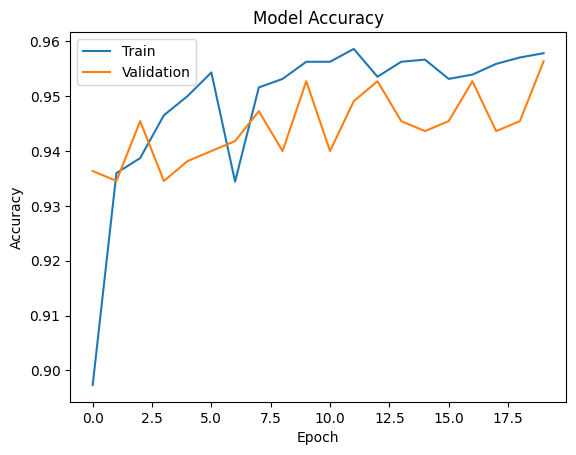

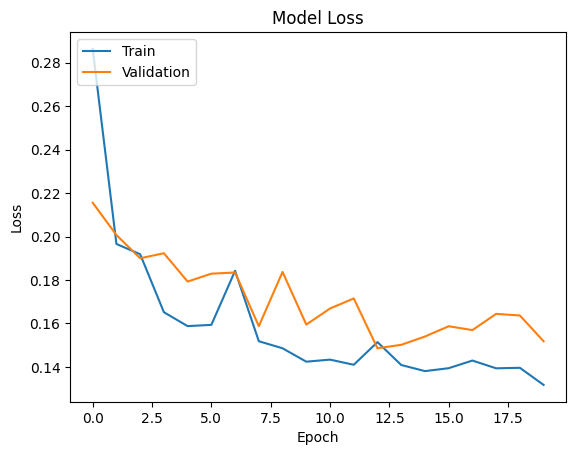

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# ****Diabet Retinopathy Detection Section****

All the result below shows that with or without augmentation process, the model is still can show the correct predicted probabilities

**CNN**

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class1(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')




1/1 [==============================] - 1s 572ms/step
DR


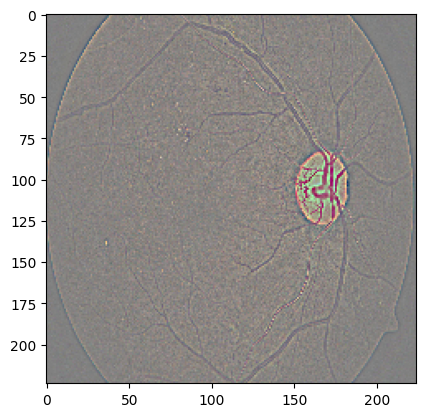

In [ ]:
predict_class1('/content/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/03a7f4a5786f.png')

**CNN NO AUGMENTATION**

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_classCNNaug(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("CNNaug.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')

1/1 [==============================] - 0s 437ms/step
No DR


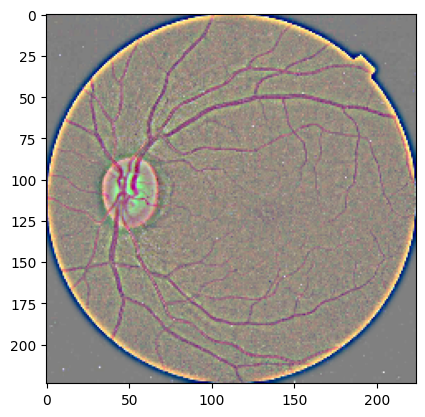

In [ ]:
predict_classCNNaug('/content/gaussian_filtered_images/gaussian_filtered_images/No_DR/0125fbd2e791.png')

**MobileNetV2**

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class2(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("MobileNetV2.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')

1/1 [==============================] - 1s 821ms/step
DR


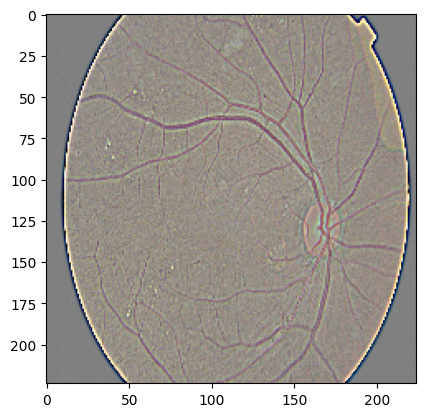

In [ ]:
predict_class2('/content/gaussian_filtered_images/gaussian_filtered_images/Moderate/00e4ddff966a.png')

**MobileNetV2 NO AUGMENTATION**

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class3(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("MobileNetV2aug.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')

1/1 [==============================] - 1s 812ms/step
DR


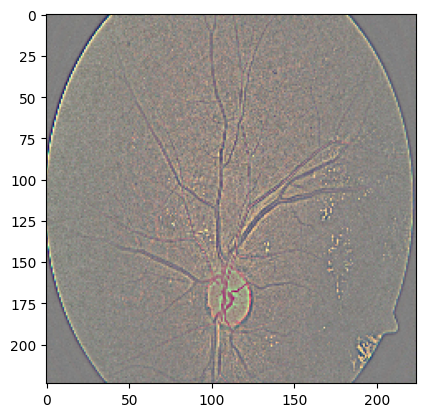

In [ ]:
predict_class3('/content/gaussian_filtered_images/gaussian_filtered_images/Mild/03e25101e8e8.png')

## CNN
**No Augmentation**

Loss:  0.656

Accuracy:  0.734

**Augmentation**

Loss:  0.295

Accuracy:  0.878

## Mobile Net V2
**No Augmentation**

Loss:  0.0968

Accuracy:  0.969

AUC:  0.988

**Augmentation**

Loss:  0.116

Accuracy:  0.959

AUC:  0.993

###### The accuracy result of MobileNetV2 without augmentation has slightly better than the augmentation one. But at the AUC metrics, the augmentation MobileNetV2 model is better, it means that the model is performing better at ranking the predicted probabilities of the positive class than at making accurate predictions.

 MobileNetV2 has a better perfomance than the CNN model because it has more experienced (rumit) architecture than the simple CNN model. MobileNetV2 is a deep neural network that uses a combination of convolutional layers, depthwise separable convolutions, and pointwise convolutions, which makes it more effective at learning complex features in images.

 MobileNetV2 is also pre-trained on a large dataset, ImageNet, which contains millions of images. Pre-training on this dataset enables the model to learn general features that can be applied to a wide range of tasks, including your specific task. On the other hand, the CNN model was trained from scratch, without any pre-training, which could lead to a suboptimal performance.



In [ ]:
while True:pass